<a href="https://colab.research.google.com/github/Lchet/rcnn-plane/blob/main/R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

gpu_available = tf.test.is_gpu_available()
print(f"Running on GPU: {tf.test.gpu_device_name()}")
display(device_lib.list_local_devices())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Running on GPU: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 516030796250102460, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16185556992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8753543131235867608
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
working_dir = "/content/drive/MyDrive/AI/Online Courses/Python Course/Bootcamp 12 Primrose/ML/R-CNN"

# Get Files
This section get the zip files from github into colab env

In [9]:
from google.colab import files

In [10]:
!wget https://github.com/1297rohit/RCNN/raw/master/Airplanes_Annotations.zip

--2021-10-28 06:55:40--  https://github.com/1297rohit/RCNN/raw/master/Airplanes_Annotations.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip [following]
--2021-10-28 06:55:41--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181072 (177K) [application/zip]
Saving to: ‘Airplanes_Annotations.zip’

Airplanes_Annotatio 100%[===================>] 176.83K  --.-KB/s    in 0.03s   

2021-10-28 06:55:41 (5.62 MB/s) - ‘Airplanes_Annotations.zip’ saved [181072/181072]



In [11]:
!wget https://github.com/1297rohit/RCNN/raw/master/Images.zip

--2021-10-28 06:55:44--  https://github.com/1297rohit/RCNN/raw/master/Images.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip [following]
--2021-10-28 06:55:44--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]  12.09M  --.-KB/s    in 0.1s    

2021-10-28 06:55:46 (81.6 MB/s) - ‘Images.zip’ saved [12680736/12680736]



In [ ]:
!unzip "/content/Images.zip" -d "/content/data/"

In [ ]:
!unzip "/content/Airplanes_Annotations.zip" -d "/content/data/"

# Building Data

In [14]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


#### Load a sample of images with annotation

In [171]:
# plot some image and its annotation
# we assume a naming convetion that each annotation file has a 
# corresponding img file with same name but different extension file
# type

img_dir = "./data/Images"
annot_dir = "./data/Airplanes_Annotations" 

def plot_img(n_img=8):
  img_files = os.listdir(img_dir)
  annot_files = os.listdir(annot_dir)
  # plot n_img images to just to chaeck we are ok
  fig = plt.figure(figsize=(10,5))
  fig.tight_layout()
  for i, annot_file in enumerate(annot_files[:n_img]):
    img_name = annot_file.split(".")[0]+".jpg"
    
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
    plt.subplot(2,np.ceil(n_img/2),i+1)
    img = cv2.imread(os.path.join(img_dir,img_name))
    df = pd.read_csv(os.path.join(annot_dir, annot_file))
    for row in df.iterrows():
      x1 = int(row[1][0].split(" ")[0])
      y1 = int(row[1][0].split(" ")[1])
      x2 = int(row[1][0].split(" ")[2])
      y2 = int(row[1][0].split(" ")[3])
      cv2.rectangle(img,(x1,y1),(x2,y2),(255,20,0), 1)
      #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    plt.title(img_name)
    plt.imshow(img)
  
 

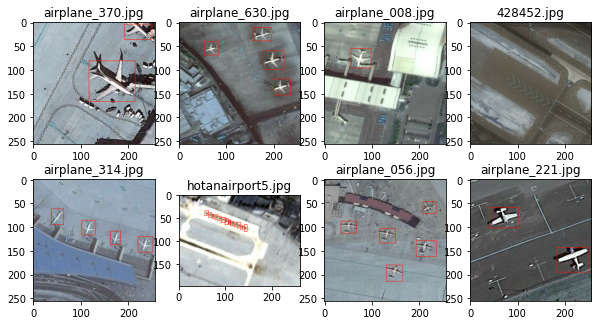

In [16]:
plot_img(n_img=8)

In [172]:
# Utility function for debug
def plot_img_for_debug(img_name, threshold):
  img_dir = "./data/Images"
  annot_dir = "./data/Airplanes_Annotations" 
  
  resized = []
  fig = plt.figure(figsize=(15,10))
  fig.tight_layout()
  
  annot_file = img_name.split(".")[0]+".csv"
  img = cv2.imread(os.path.join(img_dir,img_name))
  img_annot = img.copy()
  df = pd.read_csv(os.path.join(annot_dir, annot_file))
  for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img_annot,(x1,y1),(x2,y2),(255,20,0), 1)
    
  ss_rects = get_ss_rectangles(img, img_name)
  #print(f"{len(ss_rects)} ss rectangles")

  img_iou = img.copy()
  annot_rects = get_annot_rectangles(df)
  #print(f"{len(annot_rects)} annot rectangles")
  
  for i, rect in (enumerate(ss_rects)):
      x, y, w, h = rect
      #cv2.rectangle(img_iou, (x, y), (x+w, y+h), (80,230,0), 1, cv2.LINE_AA)
      for annot_rect in annot_rects:
        iou = get_iou(annot_rect,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
        if iou > threshold:
          tmp_img = img[y:y+h,x:x+w]
          resized_img = cv2.resize(tmp_img, (224,224), interpolation = cv2.INTER_AREA)
          resized.append(resized_img)
          label = True
          cv2.rectangle(img_iou, (x, y), (x+w, y+h), (80,230,0), 1, cv2.LINE_AA)
          #print(f"true: inx {i}")
        elif iou < 1-threshold:
          neg = True
  resized.append(img_annot)
  resized.append(img_iou)
  plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
  for i, img in enumerate(resized):
    plt.subplot(2, int(np.ceil(len(resized)/2)), i+1)
    plt.imshow(img)
  plt.show()
    
  

#### Selective Search function
Debug function to test and understand how to use cv2 selective search

In [18]:
def show_selective_serach(n_img=8):
  cv2.setUseOptimized(True);
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  img_files = os.listdir(img_dir)
  
  fig = plt.figure(figsize=(10,5))
  fig.tight_layout()
  for i, annot_file in enumerate(img_files[:n_img]):
    img_name = annot_file.split(".")[0]+".jpg"
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
    plt.subplot(2,np.ceil(n_img/2),i+1)
    im = cv2.imread(os.path.join(img_dir,img_name))
    ss.setBaseImage(im)
    ss.switchToSelectiveSearchFast()

    rects = ss.process()
    imOut = im.copy()
    for i, rect in (enumerate(rects)):
        x, y, w, h = rect
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (80,230,0), 1, cv2.LINE_AA)
    plt.title(img_name)
    plt.imshow(imOut)



  

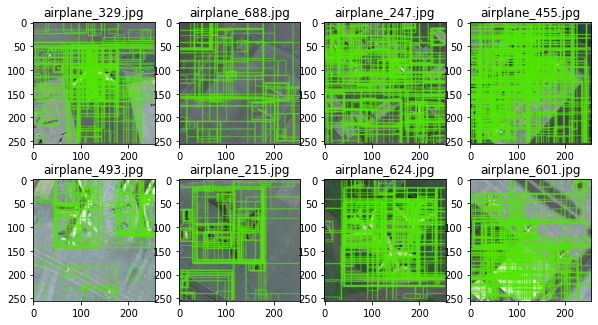

In [19]:
show_selective_serach()

In [ ]:
def get_iou(bb1, bb2):
  """
  This function was copied from https://github.com/1297rohit/RCNN
  #It does intersection over union of given two rectangles - bb1, bb2 (boundary box)
  bb1 and bb2 are expected to be python dictionary
  """
  
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Create data labeld for training

In [21]:
def get_annot_rectangles(df):
  """
  Get the annotation rectangles from a pandas DataFrame
  The DataFrame is created when reach the annotation csv file herebelow
  """
  annot_rectangles=[]
  for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    annot_rectangles.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
  return annot_rectangles


In [22]:
def create_iou_pictures(img, annot_rect, ss_rect, threshold = 0.7):
  """
  Create pictures from a given image based on iou (annot_rect and ss_rect)
  area threshold criteria. of
  """
  
  resized_img = None  
  x,y,w,h = ss_rect
  iou = get_iou(annot_rect,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
  
  label = False
  neg = False
  if iou > threshold:
    tmp_img = img[y:y+h,x:x+w]
    resized_img = cv2.resize(tmp_img, (224,224), interpolation = cv2.INTER_AREA)
    label = True
  elif iou < 0.2:
    tmp_img = img[y:y+h,x:x+w]
    resized_img = cv2.resize(tmp_img, (224,224), interpolation = cv2.INTER_AREA)
    neg = True
    
  return label, neg, resized_img



In [23]:
def save_img(img, file_dir, filename, generate_negative=False):
  if not os.path.isdir(file_dir):
    os.mkdir(file_dir)  
  return cv2.imwrite(os.path.join(file_dir, filename), img)



In [24]:
def get_ss_rectangles(img, file_name, verbose=0):
  """
  Get selective search rectangles (bounding boxes)
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ss_rectangles = ss.process()
  if verbose > 1:
    print(f"{file_name} has: {len(ss_rectangles)} ss rectangles")
  return ss_rectangles


In [25]:
def prepare_data_and_labels(annot_dir, img_dir, threshold=0.7, 
                            max_img_generate=30, verbose=0):
  """
    Get all plane images from img_dir and their respective annotation from 
    annot_dir. 
    For each plane img run a selective search segmentation and create 
    pictures from Intersection Over Union with the respective true annotation
    file according to threshold area
    Files that are labeled as plane are under img_dir + '/pos' 
    and others are under img_dir + '/neg'
  """

  label_pos_dir = img_dir+"/pos"
  label_neg_dir = img_dir+"/neg"
   
  # total labeled file generated from iou
  total_pos = 0
  # total negative label generated by iou
  total_neg = 0

  # loop over all pictures that start with 'airplane'
  for index, file in enumerate(os.listdir(annot_dir)):
    if file.startswith("airplane"):
      file_base = file.split(".")[0]
      file_img = file_base + ".jpg"
      print(index,file_img)
      image = cv2.imread(os.path.join(img_dir,file_img))
      df = pd.read_csv(os.path.join(annot_dir,file))
      annot_rectangles = get_annot_rectangles(df)
      imout = image.copy()
      # get selective serach rectangles
      ss_rectangles = get_ss_rectangles(imout, file_img, verbose)

      # total labled and neg-label files generated per 'airplane' picture          
      pos, neg, stop_flag = (0,0,0)
            
      # loop over all ss_rectangles and find iou according to thresholds
      # generate max_img_generate images that match threshold iou area 
      # and 1- threshold area for non label each. total of 2*max_img_generate
      # pictures can be crated. save file to disk under label_true_dir and
      # label_neg_dir
      for ss_idx, ss_rect in enumerate(ss_rectangles):
          if ss_idx < 2000 and stop_flag == 0:
              for annot_rect in annot_rectangles:                                    
                # allow maximum 30 pictures with plans
                if (pos < max_img_generate) or (neg < max_img_generate):
                    n_true, n_false, iou_img = create_iou_pictures(imout, annot_rect, ss_rect, threshold)                            
                                                
                    if verbose > 4:
                      print(f"img: {file_base} found: {n_true} iou and {n_false}")
                      print(f"for {annot_rect} annot given {ss_rect} ss rect")

                    if n_true:
                      pos += 1
                      total_pos += 1
                      file_name = file_base + str(f"_{pos}_{total_pos}.jpg")
                      assert( (iou_img, label_pos_dir, file_name))
                      if verbose >= 3:
                        print(f"img pos label: {file_name} saved.")
                        print(f"annot: {annot_rect}, ss rect: {ss_rect}")
                    elif n_false and neg <= max_img_generate:
                      neg += 1
                      total_neg +=1
                      file_name = file_base + str(f"_{neg}_{total_neg}.jpg")
                      assert(save_img(iou_img, label_neg_dir, file_name))
                                           
                      if verbose >= 3:
                        print(f"img neg label: {file_name} saved.")
                        print(f"annot: {annot_rect}, ss rect: {ss_rect}")
                                              
                else :
                  if verbose:
                    print(f"max files generate for {file_base}, label:{pos}, neg-label: {neg}")
                    print(f"Total label: {total_pos}, total neg-label: {total_neg}")

                  stop_flag = 1
      if verbose >= 2:
        if(index == 5):
          print(f"{total_pos+total_neg} files were created. {index}, {file_img} breaking...")
          break
            
      print(f"idx: {index}, {file_img}, {total_pos+total_neg} files {pos} pos, {neg} neg created")
  return label_pos_dir, label_neg_dir

In [ ]:
pos_dir, neg_dir =  prepare_data_and_labels(annot_dir=annot_dir, img_dir=img_dir, threshold=0.6, verbose=0)

##Build data generator

In [27]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator( rotation_range=90,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)


In [28]:
train_data = train_gen.flow_from_directory(img_dir, target_size=(224,224), class_mode='binary', subset='training')
val_data = train_gen.flow_from_directory(img_dir, target_size=(224,224), class_mode='binary', subset='validation')



Found 28077 images belonging to 2 classes.
Found 7018 images belonging to 2 classes.


##Building test data
We will take all files that don't start with `airplane`

In [29]:
def get_test_data():
  img_files = os.listdir(img_dir)
  annot_files = os.listdir(annot_dir)
  test_img = []
  test_annot = []
  for index, file in enumerate(os.listdir(annot_dir)):
    if not file.startswith("airplane"):
      file_base = file.split(".")[0]
      file_annot = file_base + ".csv"
      test_img.append(file)
      test_annot.append(file_annot)      
  return test_img, test_annot

# Build Classification Model

In [30]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

In [31]:
# create the base pre-trained model
vgg19_model = VGG19(weights='imagenet', include_top=True)


# Freeze the base_model
vgg19_model.trainable = False
vgg19_model.layers[-2].trainable = True


till_last_layers = vgg19_model.layers[-2].output
predictions = Dense(1, activation='sigmoid')(till_last_layers)
model_vgg = keras.Model(inputs = vgg19_model.inputs, outputs=predictions)


574726144/574710816 [==============================] - 16s 0us/step


In [32]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [33]:
# config the metrics for the model
metrics = ['accuracy',
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def get_callbacks(model_name):

  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                            mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  # define checkpoints
  checkpoint_path = os.path.join(working_dir, model_name + "/training/cp.ckpt")
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  return [reduce_lr, early_stop, cp_callback]

In [109]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics)

# Fit The model

In [110]:
model_history = model_vgg.fit(train_data, epochs=15, callbacks=get_callbacks("VGG19-rcnn"), validation_data=val_data)

Epoch 1/15
878/878 [==============================] - 439s 494ms/step - loss: 0.2055 - accuracy: 0.9234 - tp: 10408.0000 - fp: 1794.0000 - tn: 15517.0000 - fn: 358.0000 - precision: 0.8530 - recall: 0.9667 - auc: 0.9731 - prc: 0.9428 - val_loss: 0.2176 - val_accuracy: 0.9201 - val_tp: 2570.0000 - val_fp: 440.0000 - val_tn: 3887.0000 - val_fn: 121.0000 - val_precision: 0.8538 - val_recall: 0.9550 - val_auc: 0.9686 - val_prc: 0.9321

Epoch 00001: saving model to /content/drive/MyDrive/AI/Online Courses/Python Course/Bootcamp 12 Primrose/ML/R-CNN/VGG19-rcnn/training/cp.ckpt
Epoch 2/15
878/878 [==============================] - 433s 494ms/step - loss: 0.1944 - accuracy: 0.9267 - tp: 10285.0000 - fp: 1577.0000 - tn: 15734.0000 - fn: 481.0000 - precision: 0.8671 - recall: 0.9553 - auc: 0.9737 - prc: 0.9454 - val_loss: 0.2094 - val_accuracy: 0.9222 - val_tp: 2535.0000 - val_fp: 390.0000 - val_tn: 3937.0000 - val_fn: 156.0000 - val_precision: 0.8667 - val_recall: 0.9420 - val_auc: 0.9696 - val

## Evaluating model

In [111]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [112]:
def evaluate_model(model, history):
  plot_metrics(history)
  


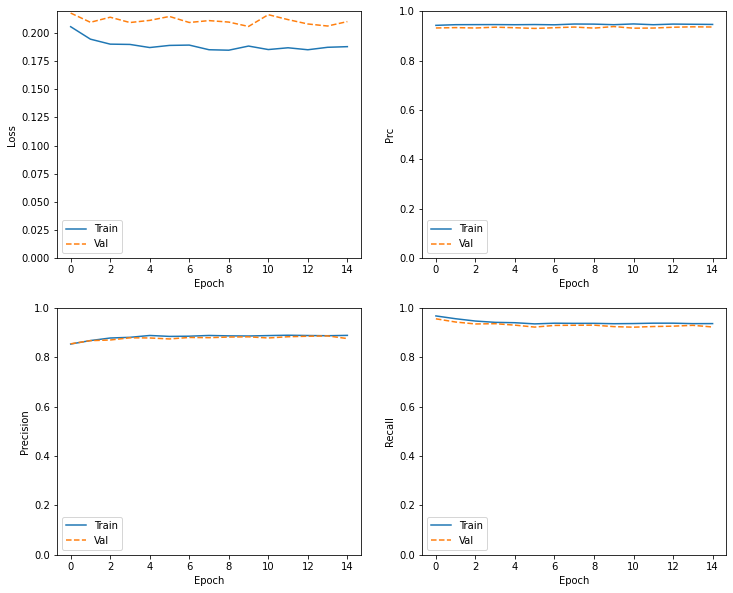

In [113]:
evaluate_model(model_vgg, model_history)


##Save weights
This section is not really needed since I have used the checkpoints callbacks.
This section was mostly for trying and testing how to save model weights

In [155]:
os.path.join(working_dir, "VGG19-rcnn")

'/content/drive/MyDrive/AI/Online Courses/Python Course/Bootcamp 12 Primrose/ML/R-CNN/VGG19-rcnn'

In [156]:
vgg19_model.save_weights(os.path.join(working_dir, "VGG19-rcnn"))

#Restore Weigths example

In [129]:
checkpoint_path = os.path.join(working_dir, "VGG19-rcnn/training/cp.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [130]:
checkpoint_dir


'/content/drive/MyDrive/AI/Online Courses/Python Course/Bootcamp 12 Primrose/ML/R-CNN/VGG19-rcnn/training'

In [131]:
path_for_ls = f"\"{checkpoint_dir}\""
!ls {path_for_ls}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
model_vgg.load_weights(checkpoint_path)

#Predict
The predict function takes as input a picture that the model hasn't seen before, search for airplanes and segment them in green rectangles

In [139]:
def predict_img(model, file_path, threshold = 0.9):
  """
  Take as input a full path of a given image pass the trained model plane classifier as well as threshold.
  Returns the image with plane segmentaion in green
  """
  
  img = cv2.imread(file_path)
  ss_rectangles = get_ss_rectangles(img, "")
  
  img_out = img.copy()
  for ss_idx, ss_rect in enumerate(ss_rectangles):
      if ss_idx < 2000:
          x,y,w,h = ss_rect
          tmp_img = img_out[y:y+h,x:x+w]
          img_resized = cv2.resize(tmp_img, (224,224), interpolation = cv2.INTER_AREA)
          img = np.expand_dims(img_resized, axis=0)
          pred = model.predict(img)
          if pred > threshold:
              cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  plt.figure()
  plt.imshow(img_out)
  

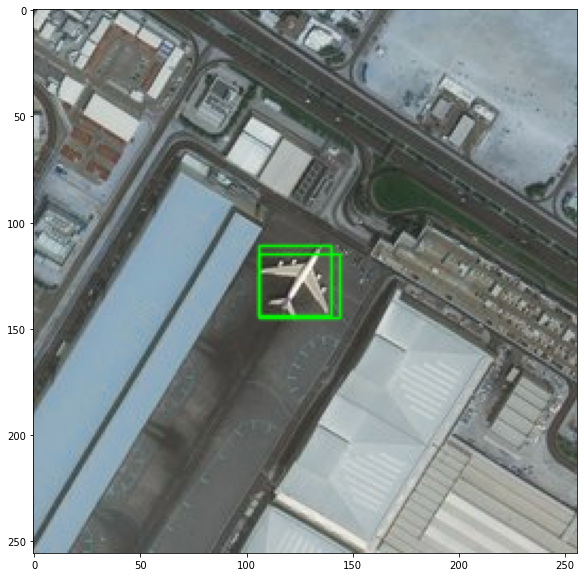

In [170]:
predict_img(model_vgg, "/content/data/Images/428492.jpg", threshold = 0.75)